In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

! pip install shap
import shap
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr

from matplotlib import pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Function to generate random feature set with given parameters
def F_set(low, high, N, theta):
    rho_0 = np.random.uniform(low, high, N)
    F = np.column_stack((rho_0 * np.cos(theta)))

    return F

In [ ]:
# Function to create feature set based on given parameters
def make_feature(N0, N1, flavour, POut):
    N0_Out = round(N0 * POut)
    N1_Out = round(N1 * POut)
    N0_effective = N0 - N0_Out
    N1_effective = (N0 + N1) - (N0_Out + N1_Out + N0_effective)

    theta_N0_outliers = np.random.uniform(0, 2 * np.pi, N0_Out)
    theta_N1_outliers = np.random.uniform(0, 2 * np.pi, N1_Out)
    theta_N0 = np.random.uniform(0, 2 * np.pi, N0_effective)
    theta_N1 = np.random.uniform(0, 2 * np.pi, N1_effective)

    outlier_low = 1
    outlier_high = 50

    if flavour == 'VS':
        class_0_low = 0
        class_0_high = 1
        class_1_low = 1
        class_1_high = 2
    elif flavour == 'S':
        class_0_low = 0
        class_0_high = 1.25
        class_1_low = 0.75
        class_1_high = 2
    elif flavour == 'W':
        class_0_low = 0
        class_0_high = 1.5
        class_1_low = 0.5
        class_1_high = 2
    elif flavour == 'VW':
        class_0_low = 0
        class_0_high = 1.75
        class_1_low = 0.25
        class_1_high = 2
    elif flavour == 'I':
        return np.random.normal(0, 1, (N0 + N1, 1)).T

    class_0 = F_set(class_0_low, class_0_high, N0_effective, theta_N0)
    class_1 = F_set(class_1_low, class_1_high, N1_effective, theta_N1)
    F = np.concatenate((class_0, class_1), axis=1)

    if N0_Out > 0:
        class_0_outliers = F_set(outlier_low, outlier_high, N0_Out, theta_N0_outliers)
        F = np.concatenate((F, class_0_outliers), axis=1)

    if N1_Out > 0:
        class_1_outliers = F_set(outlier_low, outlier_high, N1_Out, theta_N1_outliers)
        F = np.concatenate((F, class_1_outliers), axis=1)

    return F

In [ ]:
# Function to generate synthetic dataset
def synthetic_dataset(N0, N1, Rank, POut, filepath):
    D = np.hstack((np.zeros(N0), np.ones(N1)))
    D = D.reshape(-1, 1)

    header_set = []
    flavour_map = {'VS': 'Very Strong', 'S': 'Strong', 'W': 'Weak', 'VW': 'Very Weak', 'I': 'Irrelevant'}
    for i, flavour in enumerate(Rank):
        F = make_feature(N0, N1, flavour, POut)
        D = np.hstack((D, F.T))
        feature_header = 'Feature' + str(i + 1) + ' ' + flavour_map[flavour]
        header_set.append(feature_header)

    # Add header
    header = ['Label']
    header.extend(header_set)
    header = ','.join(header)

    np.random.shuffle(D)

    # Save data
    np.savetxt(filepath, D, header=header, comments='', delimiter=',', fmt='%f')


In [ ]:
# Function to normalize the feature importance values between 0 and 1
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

# Function to assign feature importance ranks from the input feature importance score
def FT_rank(arr):
    sorted_arr = sorted(arr, reverse=True)
    rank = [sorted_arr.index(value) + 1 for value in arr]
    return rank

In [ ]:
# Experiment to see the performance of ensemble of SHAP, Permutation Feature Importance, and Inbuilt Xgboost (gini) for different impurity percentage in the data
impurity_perc_set = [round(x * 0.05, 2) for x in range(100)]


N0 = 5000
N1 = 5000
filepath = "data.csv"

Rank = ['VS', 'S', 'W', 'VW', 'I']

FI_Ground_Truth = [1, 2, 3, 4, 5]

spearman_corr_SHAP_set = []
spearman_corr_perm_set = []
spearman_corr_inbuilt_set = []
spearman_corr_ensemble_set = []
accuracy_set = []

for impurity_perc in impurity_perc_set:

    print("Impurity Percentage:", impurity_perc)

    # Building the model
    synthetic_dataset(N0, N1, Rank, impurity_perc, filepath)

    df = pd.read_csv('data.csv')
    df.Label = df.Label.astype(int)

    X = df.drop('Label', axis=1).values
    y = df['Label'].values

    model = XGBClassifier(importance_type= 'gain')
    model.fit(X, y)

    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    accuracy_set.append(accuracy)

    print("Model Accuracy:", accuracy)

    # SHAP
    background = shap.maskers.Independent(X, max_samples=100)
    explainer = shap.Explainer(model, background)
    shap_values = explainer(X)
    shap_values.display_data = X
    shap_values_array = shap_values.values
    feature_importance_SHAP = np.mean(np.abs(shap_values_array), axis=0)

    norm_SHAP = normalize(feature_importance_SHAP)
    print("Normalized SHAP mean values:", norm_SHAP)

    rank_SHAP = FT_rank(norm_SHAP)
    print("SHAP Feature Importance Rank:", rank_SHAP)
    spearman_corr_SHAP, _ = spearmanr(rank_SHAP, FI_Ground_Truth)
    spearman_corr_SHAP_set.append(spearman_corr_SHAP)
    print("Spearman's Rank Correlation Coefficient for SHAP mean:", round(spearman_corr_SHAP, 2))

    # Permutation
    feature_importance_perm = permutation_importance(model, X, y).importances_mean

    norm_perm = normalize(feature_importance_perm)
    print("Normalized Permutation Feature Importance mean values:", norm_perm)

    rank_perm = FT_rank(norm_perm)
    print("Permutation Feature Importance Rank:", rank_perm)
    spearman_corr_perm, _ = spearmanr(rank_perm, FI_Ground_Truth)
    spearman_corr_perm_set.append(spearman_corr_perm)
    print("Spearman's Rank Correlation Coefficient for Permutation mean:", round(spearman_corr_perm, 2))

    # FI In-built
    feature_importance_inbuilt = model.feature_importances_

    norm_inbuilt = normalize(feature_importance_inbuilt)
    print("Normalized Inbuilt Xgboost (Gini) values:", norm_inbuilt)

    rank_inbuilt = FT_rank(norm_inbuilt)
    print("Inbuilt Xgboost (Gini) Feature Importance Rank:", rank_inbuilt)
    spearman_corr_inbuilt, _ = spearmanr(rank_inbuilt, FI_Ground_Truth)
    spearman_corr_inbuilt_set.append(spearman_corr_inbuilt)
    print("Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini):", round(spearman_corr_inbuilt, 2))

    # FI Ensemble
    norm_avg_ensemble = [(shap + perm + inbuilt) / 3 for shap, perm, inbuilt in zip(norm_SHAP, norm_perm, norm_inbuilt)]
    print("Average of Normalized Feature Importance (Ensemble):", norm_avg_ensemble)

    rank_ensemble = FT_rank(norm_avg_ensemble)
    print("Ensemble Feature Importance Rank:", rank_ensemble)
    spearman_corr_ensemble, _ = spearmanr(rank_ensemble, FI_Ground_Truth)
    spearman_corr_ensemble_set.append(spearman_corr_ensemble)
    print("Spearman's Rank Correlation Coefficient for Ensemble:", round(spearman_corr_ensemble, 2))

    print('\n')

Impurity Percentage: 0.0
Model Accuracy: 0.9517


 99%|===================| 9860/10000 [00:50<00:00]       

Normalized SHAP mean values: [1.         0.53284273 0.16413102 0.05634896 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.56382203 0.23386214 0.07202772 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.34297317 0.12547901 0.02921944 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4798793086261985, 0.17449072694824697, 0.052532037988010725, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.01
Model Accuracy: 0.9542


100%|===================| 9959/10000 [00:38<00:00]       

Normalized SHAP mean values: [1.         0.56732614 0.19091182 0.0612895  0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.50335445 0.22726426 0.07491614 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.35288924 0.12727337 0.04276231 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.47452327626920643, 0.18181648088635124, 0.05965598224174388, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.02
Model Accuracy: 0.9499


 98%|===================| 9767/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.52284175 0.22571068 0.10270694 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.55987837 0.24809945 0.11313836 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.36147052 0.13472958 0.03613299 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4813968769859079, 0.2028465726762124, 0.08399276342492164, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.03
Model Accuracy: 0.948


 99%|===================| 9914/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.53089917 0.2666977  0.10397686 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.58069164 0.28174832 0.10576369 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.3760283  0.14545216 0.04574376 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.49587303577706515, 0.23129939023585844, 0.08516143740032296, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.04
Model Accuracy: 0.9448


 99%|===================| 9946/10000 [00:37<00:00]       

Normalized SHAP mean values: [1.         0.56378079 0.29818969 0.11986252 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.56644081 0.30933559 0.12187088 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.29701012 0.13950738 0.03707089 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4757439076432546, 0.2490108889343742, 0.09293476265323854, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.05
Model Accuracy: 0.9455


 98%|===================| 9844/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.42386893 0.23301916 0.08191987 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.52112412 0.31372365 0.10276347 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.33880374 0.12472407 0.0155756  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4279322648936173, 0.22382229374069298, 0.06675297849978616, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.06
Model Accuracy: 0.9414


 98%|===================| 9841/10000 [00:37<00:00]       

Normalized SHAP mean values: [1.         0.50469035 0.35606905 0.20409578 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.58066673 0.34186646 0.16916611 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.32775664 0.15284188 0.03340318 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4710379072239544, 0.2835924643760411, 0.1355550232040815, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.07
Model Accuracy: 0.9448


 98%|===================| 9807/10000 [00:45<00:00]       

Normalized SHAP mean values: [1.         0.73485842 0.38670352 0.20984702 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.58727477 0.33567943 0.18027402 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.36886603 0.14470477 0.05041939 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5636664078293366, 0.2890292412672134, 0.14684681180540274, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.08
Model Accuracy: 0.9315


 97%|=================== | 9722/10000 [00:37<00:01]       

Normalized SHAP mean values: [1.         0.5860823  0.40121797 0.19794065 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.57804154 0.34787339 0.17042532 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.36101508 0.13631397 0.03280337 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5083796414738307, 0.29513511235812157, 0.1337231118334433, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.09
Model Accuracy: 0.9359


 99%|===================| 9904/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.6149856  0.37590121 0.26156202 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.61557967 0.36433715 0.1866315  0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.3274091  0.14661264 0.06884962 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5193247861710167, 0.2956170030697834, 0.1723477149816061, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.1
Model Accuracy: 0.9394


 98%|===================| 9790/10000 [00:38<00:00]       

Normalized SHAP mean values: [1.         0.71477737 0.43712408 0.23907915 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.63777778 0.34899471 0.10783069 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.32758307 0.1315424  0.0397986  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5600460747888274, 0.3058870633583014, 0.12890281203180268, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.11
Model Accuracy: 0.9362


 98%|===================| 9804/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.74012367 0.62215404 0.28975509 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.63827875 0.38538339 0.14077476 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.314341   0.11506756 0.04867394 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5642478105693315, 0.3742016615025705, 0.15973459749699395, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.12
Model Accuracy: 0.9371


 98%|===================| 9823/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.59931949 0.42166054 0.24748532 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.59431309 0.37256536 0.24830747 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.337687   0.13075876 0.04636572 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.510439855990399, 0.30832822145977845, 0.18071950339038534, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.13
Model Accuracy: 0.9289


100%|===================| 9990/10000 [00:37<00:00]       

Normalized SHAP mean values: [1.         0.53464765 0.41229238 0.36063849 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.63038668 0.4413655  0.24654936 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.28751034 0.13825093 0.0861816  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.48418155601324164, 0.3306362709144683, 0.23112315333370725, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.14
Model Accuracy: 0.933


100%|===================| 9998/10000 [00:37<00:00]       

Normalized SHAP mean values: [1.         0.90256138 0.46006259 0.31894126 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.60793734 0.39968668 0.19947781 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.35236827 0.11928668 0.04744633 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6209556598273743, 0.3263453178259727, 0.1886218012515396, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.15
Model Accuracy: 0.9387


 98%|===================| 9841/10000 [00:41<00:00]       

Normalized SHAP mean values: [1.         0.62379514 0.43795304 0.31741937 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.63307521 0.41370531 0.25914925 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.27127874 0.08783904 0.05043314 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5093830304733534, 0.31316580055870546, 0.209000589849754, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.16
Model Accuracy: 0.9351


 98%|===================| 9826/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.83572974 0.48629538 0.32605217 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.65796233 0.41363442 0.30907534 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.32169652 0.14208706 0.067906   0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6051295284498033, 0.3473389532459347, 0.2343445032174847, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.17
Model Accuracy: 0.934


 98%|===================| 9770/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.59887552 0.48676278 0.45419891 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.65641814 0.43592841 0.33721313 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.28428853 0.10327403 0.07992642 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5131940626854615, 0.34198840726612545, 0.29044615648342453, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.18
Model Accuracy: 0.9361


 98%|===================| 9809/10000 [00:38<00:00]       

Normalized SHAP mean values: [1.         0.71710099 0.48034188 0.39173443 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.68452515 0.47665238 0.35675615 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.26957992 0.13498677 0.08763652 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5570686860806923, 0.36399367861607596, 0.27870903003557995, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.19
Model Accuracy: 0.9323


 98%|===================| 9814/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.91258845 0.74927241 0.6856546  0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.6288911  0.47424393 0.31006979 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.26097563 0.13776888 0.11123577 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6008183957947644, 0.45376174100463457, 0.36898672027881524, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.2
Model Accuracy: 0.9371


 99%|===================| 9854/10000 [00:41<00:00]       

Normalized SHAP mean values: [1.         0.61724199 0.76697666 0.61583439 0.        ]
SHAP Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.63559608 0.49082517 0.33457165 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.217149   0.16926622 0.11042662 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.4899956935070972, 0.4756893535156104, 0.35361088716152994, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.21
Model Accuracy: 0.9371


 99%|===================| 9886/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.8310056  0.7040003  0.45335178 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.68172195 0.46988944 0.26605505 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.3018582  0.1628766  0.09061852 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6048619113510475, 0.4455887819607712, 0.2700084502656854, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.22
Model Accuracy: 0.9403


 99%|===================| 9918/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.74190954 0.51508507 0.41084656 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.68690476 0.57261905 0.40261905 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.27743557 0.12359475 0.12785427 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5687499592144353, 0.40376628927728436, 0.3137732945186326, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.23
Model Accuracy: 0.9405


100%|===================| 9995/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.94717351 0.77521456 0.69769104 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.75807285 0.53397055 0.49031258 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.30101913 0.25553906 0.15686265 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6687551651801273, 0.5215747231589084, 0.44828875678072216, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.24
Model Accuracy: 0.9422


 99%|===================| 9886/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.92235125 0.69252843 0.38514384 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.7285161  0.61607359 0.34906802 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.59559083 1.         0.37274215 0.08930188 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.865196943283081, 0.8836224504536127, 0.5604480545925221, 0.2745045819674328, 0.0]
Ensemble Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.25
Model Accuracy: 0.9405


100%|===================| 9974/10000 [00:42<00:00]       

Normalized SHAP mean values: [1.         0.70970107 0.69833201 0.60973094 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.75804924 0.53503788 0.45383523 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.6178042  0.19968936 0.37276566 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6951848483445473, 0.4776864144677393, 0.4787772748573939, 0.0]
Ensemble Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.26
Model Accuracy: 0.947


 99%|===================| 9868/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.89036654 0.63702081 0.59697977 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.7464908  0.59741045 0.41299613 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.5584982  0.4912161  1.         0.12476069 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.8528327345848083, 0.7093578114328309, 0.744810422741938, 0.3782455270116638, 0.0]
Ensemble Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.27
Model Accuracy: 0.9472


 98%|===================| 9829/10000 [00:41<00:00]       

Normalized SHAP mean values: [1.         0.83103086 0.79688922 0.63136489 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.80492136 0.69216134 0.50215627 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.6253469  0.33651996 1.         0.4566425  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.8751156330108643, 0.6574907266156091, 0.8296835190378898, 0.5300545557805182, 0.0]
Ensemble Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.28
Model Accuracy: 0.9476


 99%|===================| 9879/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.72184262 0.7669438  0.58215413 0.        ]
SHAP Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.77070381 0.68751554 0.57125093 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.704887   0.43265703 1.         0.6103053  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.9016289909680685, 0.6417344876052962, 0.8181531149972883, 0.5879034568987379, 0.0]
Ensemble Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.29
Model Accuracy: 0.9536


 98%|===================| 9798/10000 [00:40<00:00]       

Normalized SHAP mean values: [0.87864714 1.         0.64131483 0.65285547 0.        ]
SHAP Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.8
Normalized Permutation Feature Importance mean values: [1.         0.85192511 0.69738924 0.60627637 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.41448715 0.32566658 0.9434056  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.9595490479239639, 0.7554707529256449, 0.5547902160543932, 0.7341791570656432, 0.0]
Ensemble Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.3
Model Accuracy: 0.9524


 98%|===================| 9751/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.73321273 0.83140818 0.60946814 0.        ]
SHAP Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.86938493 0.74098134 0.56821009 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.5637243  0.6888244  1.         0.14696904 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.6
Average of Normalized Feature Importance (Ensemble): [0.8545747598012289, 0.7638073609503038, 0.8574631749255811, 0.4415490880267508, 0.0]
Ensemble Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.31
Model Accuracy: 0.9584


 98%|===================| 9795/10000 [00:42<00:00]       

Normalized SHAP mean values: [1.         0.69272945 0.88819793 0.66337233 0.        ]
SHAP Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.84006462 0.7955035  0.71109316 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.5887514  0.3003844  0.75233257 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.8629171252250671, 0.6110594895970004, 0.8120113328664217, 0.7914884974728128, 0.0]
Ensemble Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.32
Model Accuracy: 0.9594


 99%|===================| 9890/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.78198908 0.7641612  0.67873225 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.81615215 0.76074972 0.68715546 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.49409077 0.37334305 0.5939176  1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.8313635885715485, 0.6571614274795078, 0.7062761790822721, 0.7886292369664764, 0.0]
Ensemble Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.33
Model Accuracy: 0.9554


100%|===================| 9974/10000 [00:40<00:00]       

Normalized SHAP mean values: [0.88140608 1.         0.88024023 0.80644822 0.        ]
SHAP Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.91805866 0.82875181 0.69959227 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.35849428 0.16553135 1.         0.26165804 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.7466334550581055, 0.694530004405736, 0.9029973469008712, 0.589232843761807, 0.0]
Ensemble Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.34
Model Accuracy: 0.9603


 97%|=================== | 9735/10000 [00:39<00:01]       

Normalized SHAP mean values: [1.         0.93996505 0.90847607 0.95752826 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.86901335 0.79023816 0.75608479 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.4389836  0.57526135 0.34120983 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.812994529803594, 0.794746585311123, 0.6799746853446663, 0.9045376835302824, 0.0]
Ensemble Feature Importance Rank: [2, 3, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.35
Model Accuracy: 0.9607


100%|===================| 9964/10000 [00:41<00:00]       

Normalized SHAP mean values: [1.         0.72300525 0.85853326 0.8237307  0.        ]
SHAP Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.80180984 0.85317359 0.72839664 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.51213396 1.         0.7022529  0.3501089  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.8373779853185018, 0.8416050282665178, 0.8046532593341041, 0.6340787431865113, 0.0]
Ensemble Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.36
Model Accuracy: 0.9654


 99%|===================| 9916/10000 [00:41<00:00]       

Normalized SHAP mean values: [1.         0.93918704 0.80605239 0.96863937 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.91724231 0.8390898  0.82635785 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.2288379  0.12426397 0.46230304 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6950890852788291, 0.5898020542613316, 0.7524334195871409, 0.0]
Ensemble Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.37
Model Accuracy: 0.9633


 99%|===================| 9885/10000 [00:39<00:00]       

Normalized SHAP mean values: [0.79218116 0.64936281 1.         0.71328338 0.        ]
SHAP Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [1.         0.89518812 0.91745585 0.74712055 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.4288646  0.469087   1.         0.64589345 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.7403485866137646, 0.6712126446486738, 0.9724852828256975, 0.7020991295751998, 0.0]
Ensemble Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.38
Model Accuracy: 0.965


 99%|===================| 9868/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.73181203 0.87113839 0.94095517 0.        ]
SHAP Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [1.         0.94496979 0.93026005 0.8988705  0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.2575958  0.43498424 1.         0.19821508 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.6
Average of Normalized Feature Importance (Ensemble): [0.7525319357713064, 0.7039220194119026, 0.9337994796624609, 0.6793469169529066, 0.0]
Ensemble Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.39
Model Accuracy: 0.9678


 98%|===================| 9787/10000 [00:40<00:00]       

Normalized SHAP mean values: [0.86418624 1.         0.88403382 0.93172441 0.        ]
SHAP Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [1.         0.96715886 0.92655295 0.79493381 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.31025416 0.5068396  1.         0.41333878 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.724813464604094, 0.8246661442846, 0.9368622586736035, 0.7133323334394176, 0.0]
Ensemble Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.4
Model Accuracy: 0.9661


 99%|===================| 9887/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.68622221 0.82179916 0.88982395 0.        ]
SHAP Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [1.         0.88333333 0.92487745 0.94509804 0.        ]
Permutation Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [0.42644334 0.6396848  0.5663663  1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.8088144461313883, 0.7364134480443577, 0.77101430889111, 0.9449739959796517, 0.0]
Ensemble Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.41
Model Accuracy: 0.9704


 98%|===================| 9799/10000 [00:39<00:00]       

Normalized SHAP mean values: [0.9831664  0.86062086 1.         0.60060332 0.        ]
SHAP Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.91485888 0.93013763 0.56449732 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [1.         0.13789621 0.25117883 0.04876965 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.9943887992897332, 0.6377919815912562, 0.7271054854136993, 0.40462342817862346, 0.0]
Ensemble Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.42
Model Accuracy: 0.9739


 98%|===================| 9809/10000 [00:38<00:00]       

Normalized SHAP mean values: [1.         0.86759897 0.71796639 0.94341964 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.94888434 0.87021858 0.91905738 0.        ]
Permutation Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.27746525 0.99212027 0.15818918 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.7591550846894582, 0.9362011905851487, 0.582124716997563, 0.9541590059170323, 0.0]
Ensemble Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.43
Model Accuracy: 0.9791


 98%|===================| 9811/10000 [00:39<00:00]       

Normalized SHAP mean values: [0.92922531 0.82834524 1.         0.86199868 0.        ]
SHAP Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [1.         0.93975624 0.96204295 0.94625653 0.        ]
Permutation Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [1.         0.2567924  0.25549775 0.28497428 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.9764084357527, 0.6749646263382082, 0.7391802339886854, 0.697743161011163, 0.0]
Ensemble Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.44
Model Accuracy: 0.983


 98%|===================| 9779/10000 [00:42<00:00]       

Normalized SHAP mean values: [0.95343175 0.83876833 0.95151805 1.         0.        ]
SHAP Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [1.         0.96316926 0.96567011 0.99579402 0.        ]
Permutation Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [0.34497297 1.         0.24410754 0.32061815 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.8
Average of Normalized Feature Importance (Ensemble): [0.7661349046927435, 0.933979198717124, 0.7204319024986829, 0.7721373911024266, 0.0]
Ensemble Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.45
Model Accuracy: 0.9838


 99%|===================| 9898/10000 [00:40<00:00]       

Normalized SHAP mean values: [0.8940446  1.         0.94732448 0.95032164 0.        ]
SHAP Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [0.92600284 1.         0.99038146 0.97584435 0.        ]
Permutation Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.4
Normalized Inbuilt Xgboost (Gini) values: [0.08689065 1.         0.1266436  0.22473913 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.6356460316657806, 1.0, 0.6881165144047413, 0.7169683776084455, 0.0]
Ensemble Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.46
Model Accuracy: 0.9884


 98%|===================| 9830/10000 [00:40<00:00]       

Normalized SHAP mean values: [1.         0.84654273 0.56280889 0.8700016  0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.94207661 0.37927493 0.91722296 0.        ]
Permutation Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [1.         0.17363109 0.02503742 0.06557071 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [1.0, 0.6540834781342174, 0.3223737459216598, 0.6175984256225816, 0.0]
Ensemble Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.47
Model Accuracy: 0.9918


 98%|===================| 9784/10000 [00:39<00:00]       

Normalized SHAP mean values: [1.         0.99440039 0.95155467 0.79549816 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.96987456 0.98807321 0.60004113 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.18701448 0.2575091  1.         0.22571635 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.7290048251549403, 0.7405946876445078, 0.9798759580574409, 0.5404185472413686, 0.0]
Ensemble Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.48
Model Accuracy: 0.9954


 97%|=================== | 9742/10000 [00:37<00:00]       

Normalized SHAP mean values: [0.99418787 1.         0.84469919 0.90825777 0.        ]
SHAP Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.8
Normalized Permutation Feature Importance mean values: [0.99439405 0.99164203 1.         0.77321374 0.        ]
Permutation Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.53447354 0.9399891  0.50836366 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.8410184869645344, 0.977210374805649, 0.7843542836840696, 0.8938238364065917, 0.0]
Ensemble Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.49
Model Accuracy: 0.9999


 99%|===================| 9858/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.8665427  1.         0.89176599 0.86234323 0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.99826707 0.85249745 0.73669725 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [1.         0.11937487 0.2117374  0.04495539 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.9555142316976029, 0.7058806485559437, 0.6520002780052357, 0.5479986210823458, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.5
Model Accuracy: 1.0


 95%|=================== | 9547/10000 [00:12<00:00]       

Normalized SHAP mean values: [0.99596763 1.         0.93444549 0.98566235 0.        ]
SHAP Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.8
Normalized Permutation Feature Importance mean values: [0.98117626 0.99450599 0.60145907 1.         0.        ]
Permutation Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.21111777 0.126247   0.49309632 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.7294205559333379, 0.7069176643489162, 0.6763336260699337, 0.9952207820424159, 0.0]
Ensemble Feature Importance Rank: [2, 3, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.51
Model Accuracy: 1.0


 99%|===================| 9921/10000 [00:36<00:00]       

Normalized SHAP mean values: [0.89625515 1.         0.95236059 0.6088864  0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.85481271 0.98937885 1.         0.35827406 0.        ]
Permutation Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [0.05731992 1.         0.26565674 0.04195064 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.6027959273737795, 0.9964596175122491, 0.7393391110789661, 0.33637037016099125, 0.0]
Ensemble Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.52
Model Accuracy: 0.9988


 98%|===================| 9803/10000 [00:34<00:00]       

Normalized SHAP mean values: [1.         0.92345828 0.69761348 0.85833054 0.        ]
SHAP Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.88461934 0.41939792 0.73492243 0.        ]
Permutation Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.22760692 0.27526382 0.04237492 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.7425356407960256, 0.6944471425738722, 0.3864621077258648, 0.8644176559573661, 0.0]
Ensemble Feature Importance Rank: [2, 3, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.53
Model Accuracy: 0.9938


 98%|===================| 9779/10000 [00:32<00:00]       

Normalized SHAP mean values: [0.90069848 1.         0.94071694 0.68966456 0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.91645594 0.73312585 1.         0.25316086 0.        ]
Permutation Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.1168997  0.24046624 1.         0.30975428 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.6446847070429217, 0.6578640293566423, 0.9802389811059834, 0.41752657018075984, 0.0]
Ensemble Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.54
Model Accuracy: 0.9883


 98%|===================| 9774/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.77200557 0.87230923 1.         0.94205104 0.        ]
SHAP Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.1
Normalized Permutation Feature Importance mean values: [0.56889907 0.54494324 1.         0.79564629 0.        ]
Permutation Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.2
Normalized Inbuilt Xgboost (Gini) values: [0.05848307 0.35606566 1.         0.43771634 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.4664625716154685, 0.5911060423056791, 1.0, 0.7251378861211676, 0.0]
Ensemble Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.55
Model Accuracy: 0.9866


 99%|===================| 9924/10000 [00:36<00:00]       

Normalized SHAP mean values: [0.68989143 0.65105327 1.         0.90694713 0.        ]
SHAP Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.2
Normalized Permutation Feature Importance mean values: [0.47502461 0.20460138 0.91350886 1.         0.        ]
Permutation Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.1
Normalized Inbuilt Xgboost (Gini) values: [1.         0.20808595 0.09201384 0.69050056 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.7216386780526426, 0.35458020161770293, 0.6685075672084265, 0.8658158974044108, 0.0]
Ensemble Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.56
Model Accuracy: 0.9832


 99%|===================| 9931/10000 [00:35<00:00]       

Normalized SHAP mean values: [1.         0.69609169 0.64049312 0.79492414 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.54581333 0.528      0.74869333 0.        ]
Permutation Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [1.         0.46091795 0.8366275  0.23687539 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [1.0, 0.5676076593035383, 0.6683735348410638, 0.5934976179686994, 0.0]
Ensemble Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.57
Model Accuracy: 0.9748


 99%|===================| 9857/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.62883603 0.69930438 1.         0.67889244 0.        ]
SHAP Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [0.30823457 0.4820188  1.         0.46209644 0.        ]
Permutation Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.09454639 0.29529977 0.7257282  1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.0
Average of Normalized Feature Importance (Ensemble): [0.34387233075895635, 0.4922076480542636, 0.9085760712623596, 0.7136629628435825, 0.0]
Ensemble Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.58
Model Accuracy: 0.97


 99%|===================| 9891/10000 [00:35<00:00]       

Normalized SHAP mean values: [1.         0.79352911 0.87307166 0.94137763 0.        ]
SHAP Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [1.         0.28280961 0.65328756 0.71190916 0.        ]
Permutation Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [0.24242494 1.         0.98131865 0.39300022 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.7474749783674876, 0.6921129087479988, 0.8358926244034626, 0.6820956694606202, 0.0]
Ensemble Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.59
Model Accuracy: 0.9659


 97%|=================== | 9702/10000 [00:34<00:01]       

Normalized SHAP mean values: [0.55288689 1.         0.87858553 0.33567517 0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.20455206 1.         0.94246973 0.00871671 0.        ]
Permutation Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.12251826 0.2604516  1.         0.03390281 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.6
Average of Normalized Feature Importance (Ensemble): [0.2933190672620291, 0.7534838716189066, 0.9403517556697417, 0.1260982266043051, 0.0]
Ensemble Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.6
Model Accuracy: 0.9629


 99%|===================| 9852/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.47621191 1.         0.76163347 0.81281246 0.        ]
SHAP Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [0.20844797 1.         0.54393915 0.722447   0.        ]
Permutation Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.06938889 1.         0.6627214  0.5318428  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.2513495885530191, 1.0, 0.656098004066277, 0.689034095517799, 0.0]
Ensemble Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.61
Model Accuracy: 0.9598


 99%|===================| 9924/10000 [00:36<00:00]       

Normalized SHAP mean values: [0.70595004 1.         0.8129106  0.58043088 0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.27570578 1.         0.41077441 0.08728309 0.        ]
Permutation Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.4841648  0.35587293 1.         0.4649313  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.4886068748583952, 0.7852909763654073, 0.7412283357119872, 0.3775484244780069, 0.0]
Ensemble Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.62
Model Accuracy: 0.9588


 98%|===================| 9758/10000 [00:33<00:00]       

Normalized SHAP mean values: [1.         0.83425603 0.68314544 0.70914371 0.        ]
SHAP Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [0.8058598  1.         0.40799562 0.52491785 0.        ]
Permutation Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.8
Normalized Inbuilt Xgboost (Gini) values: [1.         0.14955625 0.06038861 0.40640396 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.9352866009492516, 0.6612707592453863, 0.383843221889405, 0.5468218394967649, 0.0]
Ensemble Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.63
Model Accuracy: 0.9541


 98%|===================| 9775/10000 [00:35<00:00]       

Normalized SHAP mean values: [1.         0.91032247 0.74173034 0.8381167  0.        ]
SHAP Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.61282517 0.59951603 0.59588627 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.16253711 1.         0.26308256 0.11131576 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.7208457042773565, 0.8410492109643787, 0.5347763107603454, 0.5151062423273933, 0.0]
Ensemble Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.64
Model Accuracy: 0.9515


 99%|===================| 9860/10000 [00:37<00:00]       

Normalized SHAP mean values: [1.         0.85179433 0.70869168 0.99962167 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.9525    0.6815625 0.3109375 1.        0.       ]
Permutation Feature Importance Rank: [2, 3, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.4
Normalized Inbuilt Xgboost (Gini) values: [1.         0.08693882 0.03655925 0.31534225 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.9841666666666667, 0.5400985511987727, 0.3520628092473715, 0.7716546398315122, 0.0]
Ensemble Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.65
Model Accuracy: 0.9501


100%|===================| 9965/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.71385062 0.77969574 1.         0.90629824 0.        ]
SHAP Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.1
Normalized Permutation Feature Importance mean values: [0.26407613 0.18318795 1.         0.61036215 0.        ]
Permutation Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.2
Normalized Inbuilt Xgboost (Gini) values: [0.27827322 0.07206359 0.38573176 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.41873332468758706, 0.3449824242388771, 0.7952439188957214, 0.8388867938553494, 0.0]
Ensemble Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.66
Model Accuracy: 0.9372


 97%|=================== | 9701/10000 [00:34<00:01]       

Normalized SHAP mean values: [1.         0.60499123 0.53738231 0.6134132  0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.15365972 0.07109388 0.24882857 0.        ]
Permutation Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [1.         0.28479207 0.09632473 0.1855439  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [1.0, 0.34781433693087754, 0.23493363733770534, 0.3492618880851719, 0.0]
Ensemble Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.67
Model Accuracy: 0.9345


 99%|===================| 9918/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.65939304 1.         0.86901985 0.87918491 0.        ]
SHAP Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [0.10046802 1.         0.36318253 0.50608424 0.        ]
Permutation Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.05627146 1.         0.19045264 0.39258254 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.2720441731720014, 1.0, 0.4742183373618296, 0.5926172289148782, 0.0]
Ensemble Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.68
Model Accuracy: 0.9301


 97%|=================== | 9681/10000 [00:32<00:01]       

Normalized SHAP mean values: [1.         0.80091726 0.96591863 0.89554015 0.        ]
SHAP Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.46410187 0.58954213 0.26849092 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.58593327 0.10832979 1.         0.5454897  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.861977756023407, 0.4577829724518492, 0.8518202544687399, 0.5698402662930454, 0.0]
Ensemble Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.69
Model Accuracy: 0.9279


 97%|=================== | 9716/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.39821263 1.         0.99664617 0.88304051 0.        ]
SHAP Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.4
Normalized Permutation Feature Importance mean values: [0.06977386 0.96552675 0.83011583 1.         0.        ]
Permutation Feature Importance Rank: [4, 2, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.1
Normalized Inbuilt Xgboost (Gini) values: [0.07157957 1.         0.36441854 0.30773285 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.17985535017710338, 0.9885089170803455, 0.7303935111484362, 0.7302577884334434, 0.0]
Ensemble Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.7


 98%|===================| 9751/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.79374651 1.         0.69162975 0.41478623 0.        ]
SHAP Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [0.2317657  1.         0.23669389 0.03055477 0.        ]
Permutation Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.17360361 1.         0.9098806  0.25465074 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.39970527263474126, 1.0, 0.6127347392018312, 0.2333305804750582, 0.0]
Ensemble Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.71
Model Accuracy: 0.9325


 98%|===================| 9777/10000 [00:33<00:00]       

Normalized SHAP mean values: [1.         0.95675957 0.99264525 0.34254019 0.        ]
SHAP Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.9
Normalized Permutation Feature Importance mean values: [1.         0.77770885 0.85504549 0.07712986 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.07346106 0.40542766 1.         0.08478902 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.6911536852518717, 0.7132986935107944, 0.9492302463382712, 0.16815302496658968, 0.0]
Ensemble Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.6


Impurity Percentage: 0.72
Model Accuracy: 0.9262


 98%|===================| 9818/10000 [00:34<00:00]       

Normalized SHAP mean values: [1.         0.67747642 0.60753282 0.81475165 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.37       0.         0.23509434 0.03528302]
Permutation Feature Importance Rank: [1, 2, 5, 3, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.7
Normalized Inbuilt Xgboost (Gini) values: [0.5409084  0.10576504 0.42222363 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.846969465414683, 0.38441381901173716, 0.3432521497092888, 0.6832819965291147, 0.011761006289308195]
Ensemble Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.73
Model Accuracy: 0.9189


 98%|===================| 9786/10000 [00:32<00:00]       

Normalized SHAP mean values: [0.96439909 0.78891431 1.         0.81462669 0.        ]
SHAP Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [0.8652926  0.21935959 1.         0.24659551 0.        ]
Permutation Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.5
Normalized Inbuilt Xgboost (Gini) values: [0.5217669  0.5858931  1.         0.15127839 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.6
Average of Normalized Feature Importance (Ensemble): [0.7838195295748981, 0.5313889981729619, 1.0, 0.4041668624931927, 0.0]
Ensemble Feature Importance Rank: [2, 3, 1, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.74
Model Accuracy: 0.921


 97%|=================== | 9708/10000 [00:34<00:01]       

Normalized SHAP mean values: [1.         0.5058554  0.89117303 0.98843509 0.        ]
SHAP Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [1.         0.         0.53377225 0.76737381 0.02292124]
Permutation Feature Importance Rank: [1, 5, 3, 2, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.374667   0.05643162 1.         0.12025709 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.79155566294988, 0.18742900745183108, 0.8083150931071078, 0.62535533324145, 0.007640412907420923]
Ensemble Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.75
Model Accuracy: 0.9234


 99%|===================| 9921/10000 [00:36<00:00]       

Normalized SHAP mean values: [0.60321522 0.906809   1.         0.59850914 0.        ]
SHAP Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [0.17834891 1.         0.7211838  0.23104881 0.        ]
Permutation Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.4
Normalized Inbuilt Xgboost (Gini) values: [0.08483738 0.3030099  1.         0.16014843 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.2888005032177101, 0.7366062983662057, 0.9070612668743512, 0.3299021247031473, 0.0]
Ensemble Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.76
Model Accuracy: 0.928


 99%|===================| 9875/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.52696604 0.72468164 0.94048282 1.         0.        ]
SHAP Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.0
Normalized Permutation Feature Importance mean values: [0.16059783 0.6298913  1.         0.86766304 0.        ]
Permutation Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.1
Normalized Inbuilt Xgboost (Gini) values: [0.08670039 1.         0.34093034 0.3338531  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.258088087216752, 0.7848576472842254, 0.760471054541172, 0.7338387130827143, 0.0]
Ensemble Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.77
Model Accuracy: 0.9232


 98%|===================| 9835/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.34082839 1.         0.846907   0.71554179 0.        ]
SHAP Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.4
Normalized Permutation Feature Importance mean values: [0.09719023 1.         0.29640719 0.307462   0.        ]
Permutation Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.04755084 1.         0.23507415 0.3311017  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.16185648782904666, 1.0, 0.45946277786271866, 0.4513684904271526, 0.0]
Ensemble Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.4


Impurity Percentage: 0.78
Model Accuracy: 0.9075


 97%|=================== | 9741/10000 [00:32<00:00]       

Normalized SHAP mean values: [1.         0.80443223 0.805346   0.81755189 0.        ]
SHAP Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [1.         0.74345238 0.32678571 0.49880952 0.        ]
Permutation Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.7077766  1.         0.8226476  0.29656306 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.7
Average of Normalized Feature Importance (Ensemble): [0.9025922020276388, 0.8492948716034096, 0.6515930945350007, 0.5376414922396866, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.79
Model Accuracy: 0.92


 97%|=================== | 9741/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.93600324 0.31964244 1.         0.99727761 0.        ]
SHAP Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.2
Normalized Permutation Feature Importance mean values: [0.25365457 0.         0.72414727 1.         0.05170547]
Permutation Feature Importance Rank: [3, 5, 2, 1, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.2
Normalized Inbuilt Xgboost (Gini) values: [1.         0.11963618 0.40514335 0.8581276  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 4, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.6
Average of Normalized Feature Importance (Ensemble): [0.7298859388218956, 0.14642620550356963, 0.70976353873309, 0.9518017361616008, 0.017235156109005556]
Ensemble Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.8
Model Accuracy: 0.92


 99%|===================| 9928/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.85725506 0.87549233 0.98352987 1.         0.        ]
SHAP Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.0
Normalized Permutation Feature Importance mean values: [0.51369863 0.44748858 0.82420091 1.         0.        ]
Permutation Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.1
Normalized Inbuilt Xgboost (Gini) values: [0.14457397 1.         0.15326813 0.39241824 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.5051758880638312, 0.7743269707045485, 0.6536663046453306, 0.79747274518013, 0.0]
Ensemble Feature Importance Rank: [4, 2, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.81
Model Accuracy: 0.9124


 99%|===================| 9868/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.7655391  0.78446152 1.         0.73347878 0.        ]
SHAP Feature Importance Rank: [3, 2, 1, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.6
Normalized Permutation Feature Importance mean values: [0.15709757 0.38464248 1.         0.27932371 0.        ]
Permutation Feature Importance Rank: [4, 2, 1, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [0.13794957 0.48098916 0.55087525 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.0
Average of Normalized Feature Importance (Ensemble): [0.3535287453707597, 0.5500310540135731, 0.8502917488416036, 0.670934160848299, 0.0]
Ensemble Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.82
Model Accuracy: 0.9073


 99%|===================| 9938/10000 [00:33<00:00]       

Normalized SHAP mean values: [1.         0.61575928 0.87555589 0.81293297 0.        ]
SHAP Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [1.         0.78215434 0.82395498 0.63424437 0.        ]
Permutation Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.9
Normalized Inbuilt Xgboost (Gini) values: [0.9215175  0.15427515 0.92603415 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.9738391637802124, 0.5173962568678762, 0.8751816739224306, 0.8157257799125498, 0.0]
Ensemble Feature Importance Rank: [1, 4, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.83
Model Accuracy: 0.9144


 99%|===================| 9897/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.85085112 1.         0.76506808 0.8310043  0.        ]
SHAP Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.8
Normalized Permutation Feature Importance mean values: [0.15659519 1.         0.3079922  0.28070175 0.        ]
Permutation Feature Importance Rank: [4, 1, 2, 3, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.4
Normalized Inbuilt Xgboost (Gini) values: [1.         0.74427825 0.75681955 0.69194067 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 3, 2, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.6691487698772368, 0.9147594173749288, 0.6099599416542989, 0.6012155740551711, 0.0]
Ensemble Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.84
Model Accuracy: 0.9148


 99%|===================| 9880/10000 [00:36<00:00]       

Normalized SHAP mean values: [1.         0.503002   0.37174167 0.83236016 0.        ]
SHAP Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.86278109 0.34144103 0.         1.         0.1564938 ]
Permutation Feature Importance Rank: [2, 3, 5, 1, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.2
Normalized Inbuilt Xgboost (Gini) values: [1.         0.64469844 0.16526756 0.62549603 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.9542603640813828, 0.4963804906270544, 0.1790030742132044, 0.8192853969757544, 0.05216460149915875]
Ensemble Feature Importance Rank: [1, 3, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.7


Impurity Percentage: 0.85
Model Accuracy: 0.9115


 97%|=================== | 9725/10000 [00:36<00:01]       

Normalized SHAP mean values: [0.89461809 0.98983821 0.85921479 1.         0.        ]
SHAP Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [1.         0.56088561 0.         0.17158672 0.33763838]
Permutation Feature Importance Rank: [1, 2, 5, 4, 3]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [1.         0.76068354 0.3278377  0.35766637 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.9648726954688008, 0.7704691188006686, 0.3956841648497193, 0.5097510297066757, 0.11254612546125435]
Ensemble Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.86
Model Accuracy: 0.9068


 99%|===================| 9866/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.56525817 0.61292733 1.         0.92143286 0.        ]
SHAP Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.1
Normalized Permutation Feature Importance mean values: [0.3977813  0.         1.         0.35763339 0.13470681]
Permutation Feature Importance Rank: [2, 5, 1, 3, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.2
Normalized Inbuilt Xgboost (Gini) values: [0.2135722  0.60022926 0.40957463 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 2, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.3922038922747863, 0.40438553151678436, 0.8031915426254272, 0.7596887474153298, 0.0449022715266772]
Ensemble Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.87
Model Accuracy: 0.9063


100%|===================| 9980/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.84279221 0.32192026 0.64058118 1.         0.        ]
SHAP Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.3
Normalized Permutation Feature Importance mean values: [0.48445172 0.         0.36047463 1.         0.25490998]
Permutation Feature Importance Rank: [2, 5, 3, 1, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.0
Normalized Inbuilt Xgboost (Gini) values: [0.628113   0.12723866 0.18800674 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.651785631876138, 0.14971964007961408, 0.39635418580018006, 1.0, 0.08496999454446262]
Ensemble Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.88
Model Accuracy: 0.9137


 98%|===================| 9782/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.59237087 1.         0.67765574 0.55714537 0.        ]
SHAP Feature Importance Rank: [3, 1, 2, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.7
Normalized Permutation Feature Importance mean values: [0.85530547 0.96998928 0.53483387 1.         0.        ]
Permutation Feature Importance Rank: [3, 2, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.3
Normalized Inbuilt Xgboost (Gini) values: [1.         0.81660545 0.61144245 0.23894203 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [0.8158921118077158, 0.928864910203076, 0.6079773536363824, 0.5986957993939623, 0.0]
Ensemble Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.9


Impurity Percentage: 0.89
Model Accuracy: 0.9042


 99%|===================| 9931/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.77406847 1.         0.40388841 0.67488961 0.        ]
SHAP Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.8
Normalized Permutation Feature Importance mean values: [0.         1.         0.50685921 0.95956679 0.98411552]
Permutation Feature Importance Rank: [5, 1, 4, 3, 2]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.4
Normalized Inbuilt Xgboost (Gini) values: [1.         0.68383324 0.10083491 0.25583452 0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.5913561560681976, 0.8946110804875692, 0.33719417699950793, 0.6300969709631846, 0.32803850782190136]
Ensemble Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.9
Model Accuracy: 0.9017


 99%|===================| 9883/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.69398444 1.         0.63157386 0.70821866 0.        ]
SHAP Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [0.40860215 1.         0.21397849 0.5172043  0.        ]
Permutation Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.5
Normalized Inbuilt Xgboost (Gini) values: [0.9135362 0.8591566 0.6869752 1.        0.       ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 3, 4, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.4
Average of Normalized Feature Importance (Ensemble): [0.6720409282187415, 0.9530522028605143, 0.5108425116736907, 0.7418076527742782, 0.0]
Ensemble Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.5


Impurity Percentage: 0.91
Model Accuracy: 0.8985


 99%|===================| 9861/10000 [00:35<00:00]       

Normalized SHAP mean values: [0.56041751 0.72368174 0.91786171 1.         0.        ]
SHAP Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.0
Normalized Permutation Feature Importance mean values: [0.48947368 0.4122807  1.         0.82807018 0.        ]
Permutation Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.2
Normalized Inbuilt Xgboost (Gini) values: [0.21323095 0.31952536 0.87582594 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.0
Average of Normalized Feature Importance (Ensemble): [0.42104071691968104, 0.48516259976744797, 0.9312292173987565, 0.9426900584795325, 0.0]
Ensemble Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.0


Impurity Percentage: 0.92
Model Accuracy: 0.9062


100%|===================| 9989/10000 [00:34<00:00]       

Normalized SHAP mean values: [1.         0.98117166 0.27079881 0.18015628 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [0.99954792 1.         0.09403255 0.         0.24728752]
Permutation Feature Importance Rank: [2, 1, 4, 5, 3]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.6
Normalized Inbuilt Xgboost (Gini) values: [0.74298203 1.         0.10218323 0.3704563  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.8
Average of Normalized Feature Importance (Ensemble): [0.9141766501162841, 0.9937238873747792, 0.1556715286773871, 0.18353752999547476, 0.08242917420132613]
Ensemble Feature Importance Rank: [2, 1, 4, 3, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.8


Impurity Percentage: 0.93
Model Accuracy: 0.9058


 98%|===================| 9837/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.92216912 0.89179865 0.93814899 1.         0.        ]
SHAP Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.1
Normalized Permutation Feature Importance mean values: [0.65256798 0.         1.         0.04229607 0.3081571 ]
Permutation Feature Importance Rank: [2, 5, 1, 4, 3]
Spearman's Rank Correlation Coefficient for Permutation mean: 0.1
Normalized Inbuilt Xgboost (Gini) values: [0.28829476 0.62037843 0.6255574  1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.0
Average of Normalized Feature Importance (Ensemble): [0.6210106181286342, 0.504059026598255, 0.8545688048550478, 0.6807653575025178, 0.10271903323262975]
Ensemble Feature Importance Rank: [3, 4, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.2


Impurity Percentage: 0.94
Model Accuracy: 0.893


 97%|=================== | 9719/10000 [00:35<00:01]       

Normalized SHAP mean values: [0.64187608 0.16985053 0.6886535  1.         0.        ]
SHAP Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.1
Normalized Permutation Feature Importance mean values: [0.34154091 0.         0.54646545 1.         0.42335187]
Permutation Feature Importance Rank: [4, 5, 2, 1, 3]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.6
Normalized Inbuilt Xgboost (Gini) values: [0.77451694 0.24224429 0.25970966 1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 4, 3, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.3
Average of Normalized Feature Importance (Ensemble): [0.5859779758876558, 0.13736493999049573, 0.4982762000157625, 1.0, 0.14111728885358785]
Ensemble Feature Importance Rank: [2, 5, 3, 1, 4]
Spearman's Rank Correlation Coefficient for Ensemble: 0.0


Impurity Percentage: 0.95
Model Accuracy: 0.8976


100%|===================| 9975/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.43996783 1.         0.43718539 0.84074675 0.        ]
SHAP Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [0.         1.         0.15581395 0.81627907 0.06046512]
Permutation Feature Importance Rank: [5, 1, 3, 2, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.1
Normalized Inbuilt Xgboost (Gini) values: [0.40688562 1.         0.3317412  0.6069225  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 1, 4, 2, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.5
Average of Normalized Feature Importance (Ensemble): [0.28228448601805906, 1.0, 0.3082468529115545, 0.7546494422864011, 0.020155038759690186]
Ensemble Feature Importance Rank: [4, 1, 3, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.3


Impurity Percentage: 0.96
Model Accuracy: 0.8931


 98%|===================| 9768/10000 [00:35<00:00]       

Normalized SHAP mean values: [1.         0.85256073 0.54896103 0.50418821 0.        ]
SHAP Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 1.0
Normalized Permutation Feature Importance mean values: [1.         0.26680244 0.13849287 0.07026477 0.        ]
Permutation Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Permutation mean: 1.0
Normalized Inbuilt Xgboost (Gini) values: [0.72215086 1.         0.62276036 0.3524688  0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [2, 1, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.9
Average of Normalized Feature Importance (Ensemble): [0.9073836207389832, 0.706454391654475, 0.43673808472626524, 0.3089739206446218, 0.0]
Ensemble Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 1.0


Impurity Percentage: 0.97
Model Accuracy: 0.8965


 98%|===================| 9789/10000 [00:34<00:00]       

Normalized SHAP mean values: [0.72704165 0.47428631 1.         0.71235414 0.        ]
SHAP Feature Importance Rank: [2, 4, 1, 3, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.5
Normalized Permutation Feature Importance mean values: [0.         0.63656885 1.         0.70316027 0.49548533]
Permutation Feature Importance Rank: [5, 3, 1, 2, 4]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.3
Normalized Inbuilt Xgboost (Gini) values: [1.        0.6842503 0.6207801 0.4208702 0.       ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 2, 3, 4, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 1.0
Average of Normalized Feature Importance (Ensemble): [0.5756805487275375, 0.5983684830062886, 0.8735933701197306, 0.6121282074042905, 0.16516177577125665]
Ensemble Feature Importance Rank: [4, 3, 1, 2, 5]
Spearman's Rank Correlation Coefficient for Ensemble: 0.1


Impurity Percentage: 0.98
Model Accuracy: 0.901


100%|===================| 9966/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.22216482 0.60078351 0.80286933 1.         0.        ]
SHAP Feature Importance Rank: [4, 3, 2, 1, 5]
Spearman's Rank Correlation Coefficient for SHAP mean: 0.0
Normalized Permutation Feature Importance mean values: [0.         1.         0.29479769 0.43583815 0.63699422]
Permutation Feature Importance Rank: [5, 1, 4, 3, 2]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.4
Normalized Inbuilt Xgboost (Gini) values: [0.38144174 0.2357012  0.5908551  1.         0.        ]
Inbuilt Xgboost (Gini) Feature Importance Rank: [3, 4, 2, 1, 5]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.1
Average of Normalized Feature Importance (Ensemble): [0.20120218619105637, 0.6121615698200501, 0.5628407126827885, 0.8119460500963385, 0.21233140655105945]
Ensemble Feature Importance Rank: [5, 2, 3, 1, 4]
Spearman's Rank Correlation Coefficient for Ensemble: -0.3


Impurity Percentage: 0.99
Model Accuracy: 0.8835


 98%|===================| 9837/10000 [00:33<00:00]       

Normalized SHAP mean values: [0.         0.60897001 1.         0.79954835 0.8238132 ]
SHAP Feature Importance Rank: [5, 4, 1, 3, 2]
Spearman's Rank Correlation Coefficient for SHAP mean: -0.7
Normalized Permutation Feature Importance mean values: [0.         0.77427822 0.99912511 0.85564304 1.        ]
Permutation Feature Importance Rank: [5, 4, 2, 3, 1]
Spearman's Rank Correlation Coefficient for Permutation mean: -0.9
Normalized Inbuilt Xgboost (Gini) values: [1.         0.1437504  0.         0.48504075 0.18185218]
Inbuilt Xgboost (Gini) Feature Importance Rank: [1, 4, 5, 2, 3]
Spearman's Rank Correlation Coefficient for Inbuilt Xgboost (Gini): 0.2
Average of Normalized Feature Importance (Ensemble): [0.3333333333333333, 0.5089995421340311, 0.6663750364537763, 0.7134107178764921, 0.6685551245918893]
Ensemble Feature Importance Rank: [5, 4, 3, 1, 2]
Spearman's Rank Correlation Coefficient for Ensemble: -0.9




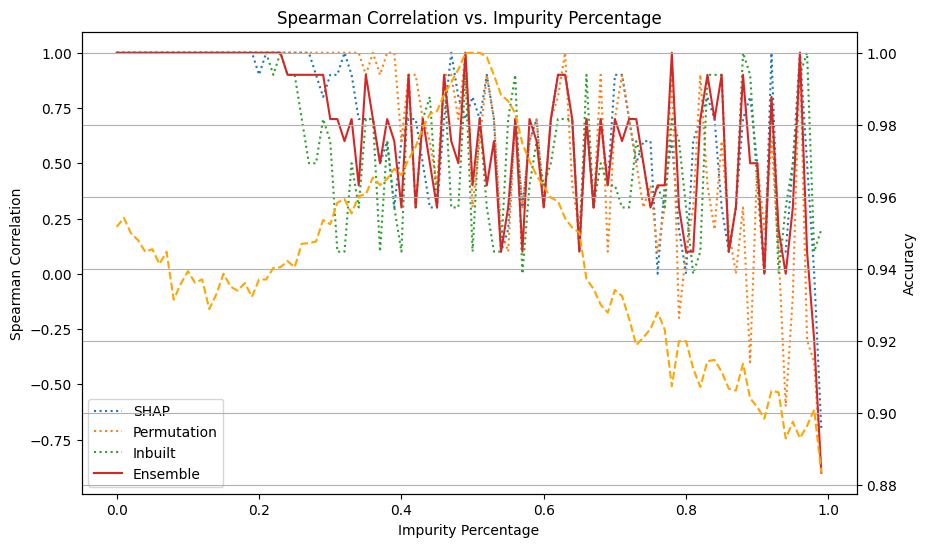

In [ ]:
# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(impurity_perc_set, spearman_corr_SHAP_set, label='SHAP', linestyle='dotted')
plt.plot(impurity_perc_set, spearman_corr_perm_set, label='Permutation', linestyle='dotted')
plt.plot(impurity_perc_set, spearman_corr_inbuilt_set, label='Inbuilt', linestyle='dotted')
plt.plot(impurity_perc_set, spearman_corr_ensemble_set, label='Ensemble')

plt.xlabel('Impurity Percentage')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation vs. Impurity Percentage')
plt.legend()

plt.twinx()
plt.plot(impurity_perc_set, accuracy_set, label='Accuracy', linestyle='dashed', color='orange')
plt.ylabel('Accuracy')

plt.grid(True)

plt.show()